<table>
    <tr>
        <td>
        <center>
        <font size="+1">If you haven't used BigQuery datasets on Kaggle previously, check out the <a href = "https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook/">Scavenger Hunt Handbook</a> kernel to get started.</font>
        </center>
        </td>
    </tr>
</table>

___ 

## Previous days:

* [**Day 1:** SELECT, FROM & WHERE](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-1/)
* [**Day 2:** GROUP BY, HAVING & COUNT()](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-2/)

____


# ORDER BY (and Dates!)

So far in our scavenger hunt, we've learned how to use the following clauses: 
    
    SELECT ... 
    FROM ...
    (WHERE) ...
    GROUP BY ...
    (HAVING) ...
We also learned how to use the COUNT() aggregate function and, if you did the optional extra credit, possibly other aggregate functions as well. (If any of this is sounds unfamiliar to you, you can check out the earlier two days using the links above.)

Today we're going to learn how change the order that data is returned to us using the ORDER BY clause. We're also going to talk a little bit about how to work with dates in SQL, because they're sort of their own thing and can lead to headaches if you're unfamiliar with them.


### ORDER BY
___

First, let's learn how to use ORDER BY. ORDER BY is usually the last clause you'll put in your query, since you're going to want to use it to sort the results returned by the rest of your query.

We're going to be making queries against this version of the table we've been using an example over the past few days. 

> **Why would the order of a table change?** This can actually happen to active BigQuery datasets, since if your table is being added to regularly [it may be coalesced every so often and that will change the order of the data in your table](https://stackoverflow.com/questions/16854116/the-order-of-records-in-a-regularly-updated-bigquery-databaseg). 

You'll notice that, unlike in earlier days, our table is no longer sorted by the ID column. 

![](https://i.imgur.com/QRgb4iL.png). 

** Ordering by a numeric column**

When you ORDER BY a numeric column, by default the column will be sorted from the lowest to highest number. So this query will return the ID, Name and Animal columns, all sorted by the number in the ID column. The row with the lowest number in the ID column will be returned first.

    SELECT ID, Name, Animal
    FROM `bigquery-public-data.pet_records.pets`
    ORDER BY ID
Visually, this looks something like this:

![](https://i.imgur.com/zEXDTKS.png)

    
** Ordering by a text column**

You can also order by columns that have text in them. By default, the column you sort on will be sorted alphabetically from the beginning to the end of the alphabet.

    SELECT ID, Name, Animal
    FROM `bigquery-public-data.pet_records.pets`
    ORDER BY Animal
![](https://i.imgur.com/E7qjnf9.png)

** Reversing the order**

You can reverse the sort order (reverse alphabetical order for text columns or high to low for numeric columns) using the DESC argument. 

> ** DESC** is short for "descending", or high-to-low.

So this query will sort the selected columns by the Animal column, but the values that are last in alphabetic order will be returned first.

    SELECT ID, Name, Animal
    FROM `bigquery-public-data.pet_records.pets`
    ORDER BY Animal DESC
![](https://i.imgur.com/DREYNFF.png)
 
### Dates
____

Finally, let's talk about dates. I'm including these because they are something that I found particularly confusing when I first learned SQL, and I ended up having to use them all. the. time. 

There are two different ways that a date can be stored in BigQuery: as a DATE or as a DATETIME. Here's a quick summary:

**DATE format**

The DATE format has the year first, then the month, and then the day. It looks like this:

    YYYY-[M]M-[D]D
* YYYY: Four-digit year
* [M]M: One or two digit month
* [D]D: One or two digit day

**DATETIME/TIMESTAMP format**

The DATETIME format is just like the date format... but with time added at the end. (The difference between DATETIME and TIMESTAMP is that the date and time information in a DATETIME is based on a specific timezone. On the other hand, a TIMESTAMP will be the same in all time zones, except for the time zone) . Both formats look like this:

    YYYY-[M]M-[D]D[( |T)[H]H:[M]M:[S]S[.DDDDDD]][time zone]
* YYYY: Four-digit year
* [M]M: One or two digit month
* [D]D: One or two digit day
* ( |T): A space or a T separator
* [H]H: One or two digit hour (valid values from 00 to 23)
* [M]M: One or two digit minutes (valid values from 00 to 59)
* [S]S: One or two digit seconds (valid values from 00 to 59)
* [.DDDDDD]: Up to six fractional digits (i.e. up to microsecond precision)
* (TIMESTAMP only) [time zone]: String representing the time zone

** Getting only part of a date **

Often, though, you'll only want to look at part of a date, like the year or the day. You can do this using the EXTRACT function and specifying what part of the date you'd like to extract. 

So this query will return one column with just the day of each date in the column_with_timestamp column: 

            SELECT EXTRACT(DAY FROM column_with_timestamp)
            FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
One of the nice things about SQL is that it's very smart about dates and we can ask for information beyond just extracting part of the cell. For example, this query will return one column with just the week in the year (between 1 and 53) of each date in the column_with_timestamp column: 

            SELECT EXTRACT(WEEK FROM column_with_timestamp)
            FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
SQL has a lot of power when it comes to dates, and that lets you ask very specific questions using this information. You can find all the functions you can use with dates in BigQuery [on this page](https://cloud.google.com/bigquery/docs/reference/legacy-sql), under "Date and time functions".  

## Example: Which day of the week do the most fatal motor accidents happen on?
___

Now we're ready to work through an example. Today, we're going to be using the US Traffic Fatality Records database, which contains information on traffic accidents in the US where at least one person died. (It's definitely a sad topic, but if we can understand this data and the trends in it we can use that information to help prevent additional accidents.)

First, just like yesterday, we need to get our environment set up. Since you already know how to look at schema information at this point, I'm going to let you do that on your own. 

> **Important note:** Make sure that you add the BigQuery dataset you're querying to your kernel. Otherwise you'll get 

In [1]:
# import package with helper functions 
import bq_helper

# create a helper object for this dataset
accidents = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="nhtsa_traffic_fatalities")

We're going to look at which day of the week the most fatal traffic accidents happen on. I'm going to get the count of the unique id's (in this table they're called "consecutive_number") as well as the day of the week for each accident. Then I'm going sort my table so that the days with the most accidents are on returned first.

In [2]:
# query to find out the number of accidents which 
# happen on each day of the week
query = """SELECT COUNT(consecutive_number), 
                  EXTRACT(DAYOFWEEK FROM timestamp_of_crash)
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
            GROUP BY EXTRACT(DAYOFWEEK FROM timestamp_of_crash)
            ORDER BY COUNT(consecutive_number) DESC
        """

Now that our query is ready, let's run it (safely!) and store the results in a dataframe: 

In [3]:
# the query_to_pandas_safe method will cancel the query if
# it would use too much of your quota, with the limit set 
# to 1 GB by default
accidents_by_day = accidents.query_to_pandas_safe(query)

And that gives us a dataframe! Let's quickly plot our data to make sure that it's actually been sorted:

Text(0.5,1,'Number of Accidents by Rank of Day \n (Most to least dangerous)')

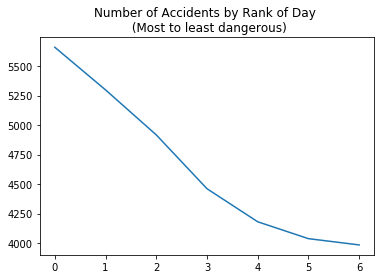

In [4]:
# library for plotting
import matplotlib.pyplot as plt

# make a plot to show that our data is, actually, sorted:
plt.plot(accidents_by_day.f0_)
plt.title("Number of Accidents by Rank of Day \n (Most to least dangerous)")

Yep, our query was, in fact, returned sorted! Now let's take a quick peek to figure out which days are the most dangerous:

In [5]:
print(accidents_by_day)

    f0_  f1_
0  5659    7
1  5298    1
2  4917    6
3  4461    5
4  4181    4
5  4038    2
6  3985    3


To map from the numbers returned for the day of the week (the second column) to the actual day, I consulted [the BigQuery documentation on the DAYOFWEEK function](https://cloud.google.com/bigquery/docs/reference/legacy-sql#dayofweek), which says that it returns "an integer between 1 (Sunday) and 7 (Saturday), inclusively". So we can tell, based on our query, that in 2015 most fatal motor accidents occur on Sunday and Saturday, while the fewest happen on Tuesday.

# Scavenger hunt
___

Now it's your turn! Here are the questions I would like you to get the data to answer:

* Which hours of the day do the most accidents occur during?
    * Return a table that has information on how many accidents occurred in each hour of the day in 2015, sorted by the the number of accidents which occurred each hour. Use either the accident_2015 or accident_2016 table for this, and the timestamp_of_crash column. (Yes, there is an hour_of_crash column, but if you use that one you won't get a chance to practice with dates. :P)
    * **Hint:** You will probably want to use the [EXTRACT() function](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#extract_1) for this.
* Which state has the most hit and runs?
    * Return a table with the number of vehicles registered in each state that were involved in hit-and-run accidents, sorted by the number of hit and runs. Use either the vehicle_2015 or vehicle_2016 table for this, especially the registration_state_name and hit_and_run columns.

In order to answer these questions, you can fork this notebook by hitting the blue "Fork Notebook" at the very top of this page (you may have to scroll up). "Forking" something is making a copy of it that you can edit on your own without changing the original.

### Q1) Which hours of the day do the most accidents occur during?

In [27]:
accidents.head('accident_2016')

,state_number,state_name,consecutive_number,number_of_vehicle_forms_submitted_all,number_of_motor_vehicles_in_transport_mvit,number_of_parked_working_vehicles,number_of_forms_submitted_for_persons_not_in_motor_vehicles,number_of_persons_not_in_motor_vehicles_in_transport_mvit,number_of_persons_in_motor_vehicles_in_transport_mvit,number_of_forms_submitted_for_persons_in_motor_vehicles,...,minute_of_ems_arrival_at_hospital,related_factors_crash_level_1,related_factors_crash_level_1_name,related_factors_crash_level_2,related_factors_crash_level_2_name,related_factors_crash_level_3,related_factors_crash_level_3_name,number_of_fatalities,number_of_drunk_drivers,timestamp_of_crash
0,19,Iowa,190192,1,1,0,0,0,1,1,...,88,0,None,0,None,0,None,1,0,2016-08-06 00:55:00+00:00
1,19,Iowa,190028,1,1,0,0,0,6,6,...,99,0,None,0,None,0,None,1,0,2016-02-13 14:16:00+00:00
2,19,Iowa,190038,1,1,0,0,0,5,5,...,99,0,None,0,None,0,None,1,0,2016-03-05 21:38:00+00:00
3,19,Iowa,190146,1,1,0,0,0,1,1,...,99,0,None,0,None,0,None,1,0,2016-06-24 18:47:00+00:00
4,19,Iowa,190043,1,1,0,0,0,1,1,...,45,0,None,0,None,0,None,1,0,2016-03-16 15:18:00+00:00


In [28]:
# Your code goes here :)

query1 = """
            SELECT COUNT(consecutive_number), 
                  EXTRACT(HOUR FROM timestamp_of_crash)
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
            GROUP BY EXTRACT(HOUR FROM timestamp_of_crash)
            ORDER BY COUNT(consecutive_number) DESC
        """

In [29]:
hour_accident = accidents.query_to_pandas_safe(query1)

hour_accident

,f0_,f1_
0,1984,18
1,1919,20
2,1913,17
3,1902,19
4,1808,16
5,1801,21
6,1731,15
7,1650,22
8,1612,0
9,1567,14


In [30]:
hour_accident.to_csv('hour_accident.csv')

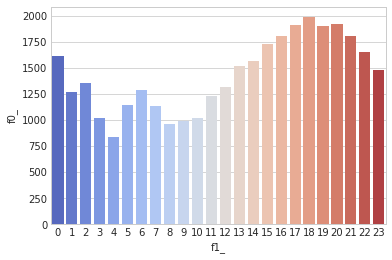

In [31]:
import seaborn as sns

sns.set_style("whitegrid") 
ax = sns.barplot(x="f1_", y="f0_", data=hour_accident, palette="coolwarm")


### Q2) Which state has the most hit and runs?

In [32]:
accidents.head('vehicle_2016')

,state_number,consecutive_number,vehicle_number,number_of_motor_vehicles_in_transport_mvit,number_of_occupants,day_of_crash,month_of_crash,hour_of_crash,minute_of_crash,first_harmful_event,...,critical_event_precrash_name,attempted_avoidance_maneuver,attempted_avoidance_maneuver_name,pre_impact_stability,pre_impact_location,crash_type,crash_type_name,fatalities_in_vehicle,driver_drinking,timestamp_of_crash
0,6,61700,1,1,2,7,8,2,36,5,...,Other Critical Precrash Event,1,No Avoidance Maneuver,Tracking,3,0,No Impact,1,Drinking,2016-08-07 02:36:00+00:00
1,32,320154,1,1,1,19,7,9,45,1,...,Over the Lane Line on Right Side of Travel Lane,16,,Skidding Laterally – Counterclockwise Rotation,2,98,"MISCELLANEOUS, CONFIGURATION M: BACKING, ETC.,...",1,No Drinking,2016-07-19 09:45:00+00:00
2,17,171005,1,1,2,28,7,18,40,7,...,Other Critical Precrash Event,99,Unknown,Precrash Stability Unknown,1,0,No Impact,1,No Drinking,2016-07-28 18:40:00+00:00
3,40,400018,1,1,1,12,1,7,10,10,...,Object in Road,1,No Avoidance Maneuver,Tracking,1,15,"SINGLE DRIVER, CONFIGURATION C: FORWARD IMPACT...",1,No Drinking,2016-01-12 07:10:00+00:00
4,48,480672,1,1,2,20,3,18,10,5,...,Other Critical Precrash Event,99,Unknown,Tracking,1,0,No Impact,1,No Drinking,2016-03-20 18:10:00+00:00


In [33]:
query2 = """
            SELECT registration_state_name, COUNT(hit_and_run)
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016`
            WHERE hit_and_run = 'Yes'
            GROUP BY registration_state_name
            ORDER BY COUNT(hit_and_run) DESC
        """

In [34]:
hit_and_run_states = accidents.query_to_pandas_safe(query2)

hit_and_run_states

,registration_state_name,f0_
0,Unknown,929
1,California,167
2,Texas,107
3,Florida,94
4,Georgia,44
5,Illinois,43
6,Ohio,39
7,North Carolina,39
8,Pennsylvania,32
9,Michigan,32


In [35]:
hit_and_run_states.to_csv('hit_and_run_states.csv')

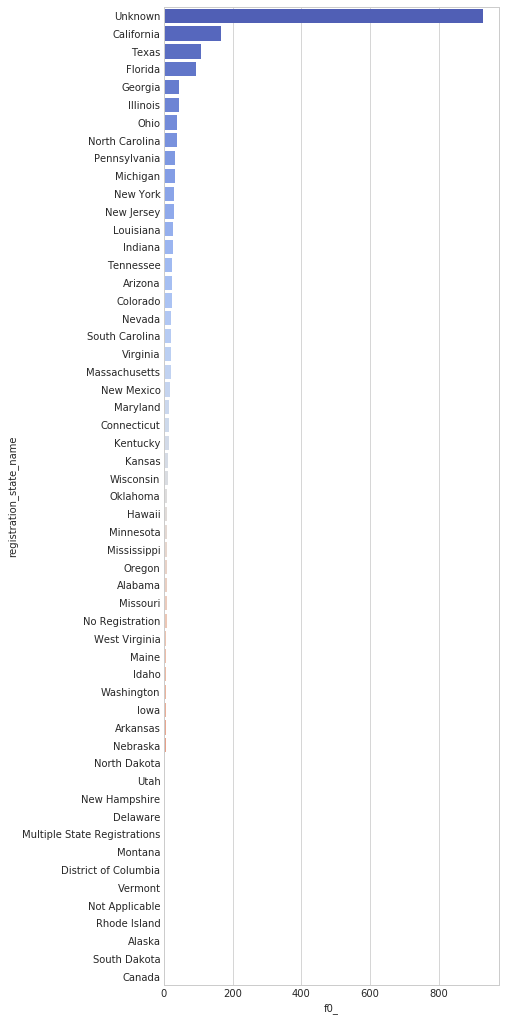

In [40]:
ax = plt.subplots(figsize=(6, 18))
sns.set_style("whitegrid") 
ax = sns.barplot(x="f0_", y="registration_state_name", data=hit_and_run_states, palette="coolwarm")
